In [3]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from scipy.io import arff
import xgboost as xgb
pd.options.display.max_columns = None
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics

## Wczytanie danych

In [132]:
df = pd.read_csv("students-all.csv")
# remove rownames
df = df.iloc[:,1:]

In [6]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,major_por
0,18,4,4,2,2,0,4,3,4,1,1,3,6,5,6,6,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0
1,17,1,1,1,2,0,5,3,3,1,1,3,4,5,5,6,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
2,15,1,1,1,2,3,4,3,2,2,3,3,10,7,8,10,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,1,0,0
3,15,4,2,1,3,0,3,2,2,1,1,5,2,15,14,15,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1,1,0
4,16,3,3,1,2,0,4,3,2,1,2,5,4,6,10,10,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0


## Funkcja ternująca na xgboost

In [7]:
def train_fast(df, max_depth, target ):
    
    # shuffling index
    df = df.sample(frac=1).reset_index(drop=True)
    n = len(df)
    
    # 5 fold cross validation
    kf = KFold(n_splits=5)
        
    
    ret = []
    
    # we will make test 10% and validation 10%
    for train_index, test_index in kf.split(df):
        
        train = df.iloc[train_index,:]
        
        v_ind = test_index[0:(len(test_index)//2)] 
        t_ind = test_index[(len(test_index)//2):len(test_index)]
        
        validation = df.iloc[v_ind,:]
        test = df.iloc[t_ind,:]
        
        label_train = train[target]
        label_val = validation[target]
        label_test = test[target]

        df_train = train.drop([target], axis = 1)
        df_test  = test.drop([target], axis = 1)
        df_val  = validation.drop([target], axis = 1)
        
        dtrain = xgb.DMatrix(data = df_train, label=label_train)
        dval = xgb.DMatrix(data = df_val, label=label_val)
        dtest = xgb.DMatrix(data = df_test, label=label_val)
        
        param = {'max_depth': max_depth, 'objective': 'binary:logistic', 'eval_metric':'auc'}
        
        evallist = [(dval, 'eval'), (dtrain, 'train')]
        
        num_round = 100
        
        bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=50)
        y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

        fpr, tpr, thresholds = metrics.roc_curve(label_test.to_numpy(), y_pred)
        roc_auc = metrics.auc(fpr, tpr)
        
        ret.append(metrics.auc(fpr, tpr))
    
    # plot figure - probably unnecessary here
    lw = 2
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)

    plt.show()

    return np.array(ret).mean(), bst

[0]	eval-auc:0.62206	train-auc:0.93891
[50]	eval-auc:0.81302	train-auc:1.00000
[99]	eval-auc:0.79706	train-auc:1.00000
[0]	eval-auc:0.54970	train-auc:0.91724
[50]	eval-auc:0.87847	train-auc:1.00000
[99]	eval-auc:0.88325	train-auc:1.00000
[0]	eval-auc:0.64533	train-auc:0.91472
[50]	eval-auc:0.75957	train-auc:1.00000
[99]	eval-auc:0.76635	train-auc:1.00000
[0]	eval-auc:0.73516	train-auc:0.93521
[50]	eval-auc:0.85069	train-auc:1.00000
[99]	eval-auc:0.84808	train-auc:1.00000
[0]	eval-auc:0.70933	train-auc:0.94515
[50]	eval-auc:0.84295	train-auc:1.00000
[99]	eval-auc:0.85270	train-auc:1.00000


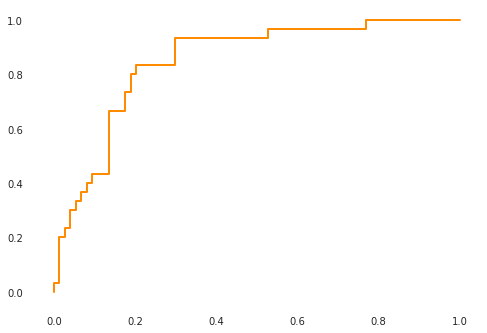

(0.8399136801871986, <xgboost.core.Booster at 0x7f72a2d06da0>)

In [8]:
train_fast(df_dummies, 13, "romantic_yes")

## Uśrednione auc

In [54]:
def get_auc_mean(df, max_depth, target = "romantic_yes", n = 10):
    auc_sum = 0
    for i in range(n):
        auc, bst = train_fast(df, max_depth, target)
        auc_sum += auc
    return auc_sum/n

Zobaczmy jak zachowuje się xgboost przy różnych parametrach max_depth. Może chwilę potrwać

In [55]:
%%capture
auc_results = []

for i in range(40): 
    auc = get_auc_mean(df_dummies, i, "romantic_yes")
    auc_results.append(auc)

In [56]:
# Zróbmy średnią kroczącą 
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [57]:
a = moving_average(np.array(auc_results),5)

Text(0.5, 1.0, 'auc based on max_depth')

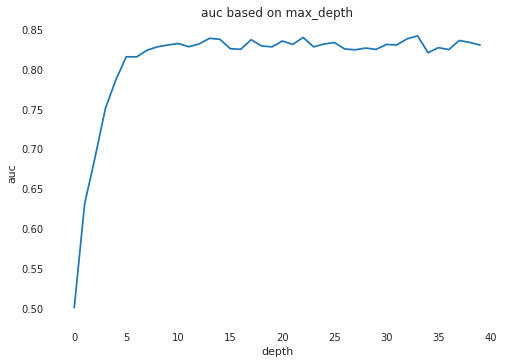

In [58]:
res = pd.DataFrame({"auc": auc_results, "depth": [i for i in range(40)]})
sns.lineplot(data = res, x = "depth", y = "auc").set_title("auc based on max_depth")

Text(0.5, 1.0, 'moving average of auc, base = 5')

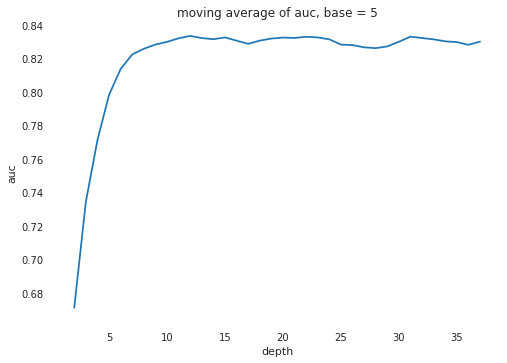

In [59]:
res = pd.DataFrame({"auc":a,"depth":np.arange(len(auc_results))[2:-2]})
sns.lineplot(data = res, x = "depth", y = "auc").set_title("moving average of auc, base = 5")

## Różne encodery

In [133]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'major'],
      dtype='object')

In [134]:
df['romantic'] = np.where(df['romantic']=='yes', 1, 0)
y = df[['romantic']].copy()
df = df.drop(columns='romantic')

In [140]:
import category_encoders as ce

encolums = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'major']

[0]	eval-auc:0.61193	train-auc:0.92412
[50]	eval-auc:0.78295	train-auc:1.00000
[99]	eval-auc:0.79091	train-auc:1.00000
[0]	eval-auc:0.64266	train-auc:0.94282
[50]	eval-auc:0.75803	train-auc:1.00000
[99]	eval-auc:0.77197	train-auc:1.00000
[0]	eval-auc:0.61925	train-auc:0.92130
[50]	eval-auc:0.80663	train-auc:1.00000
[99]	eval-auc:0.79917	train-auc:1.00000
[0]	eval-auc:0.61499	train-auc:0.92759
[50]	eval-auc:0.84028	train-auc:1.00000
[99]	eval-auc:0.83497	train-auc:1.00000
[0]	eval-auc:0.64228	train-auc:0.92945
[50]	eval-auc:0.82733	train-auc:1.00000
[99]	eval-auc:0.83546	train-auc:1.00000


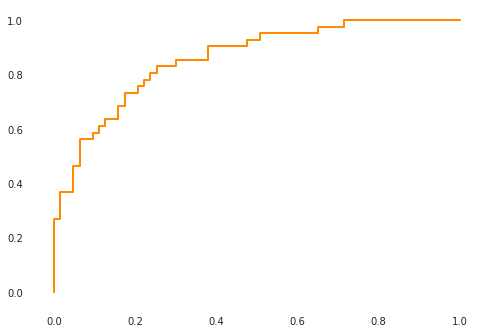

0.8235406250357589 0.8235406250357589
[0]	eval-auc:0.62101	train-auc:0.93881
[50]	eval-auc:0.86387	train-auc:1.00000
[99]	eval-auc:0.86429	train-auc:1.00000
[0]	eval-auc:0.65104	train-auc:0.92737
[50]	eval-auc:0.81695	train-auc:1.00000
[99]	eval-auc:0.81243	train-auc:1.00000
[0]	eval-auc:0.70331	train-auc:0.94491
[50]	eval-auc:0.92836	train-auc:1.00000
[99]	eval-auc:0.91926	train-auc:1.00000
[0]	eval-auc:0.68602	train-auc:0.93632
[50]	eval-auc:0.87069	train-auc:1.00000
[99]	eval-auc:0.87960	train-auc:1.00000
[0]	eval-auc:0.60647	train-auc:0.94477
[50]	eval-auc:0.78320	train-auc:1.00000
[99]	eval-auc:0.78320	train-auc:1.00000


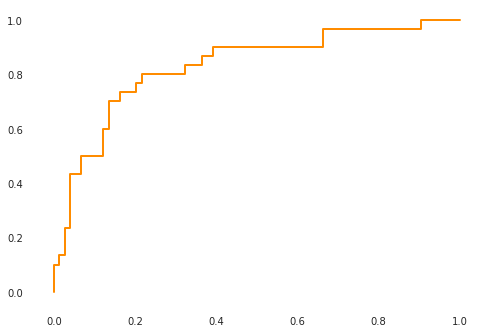

0.82883020935495 1.6523708343907089
[0]	eval-auc:0.55686	train-auc:0.94505
[50]	eval-auc:0.72569	train-auc:1.00000
[99]	eval-auc:0.73698	train-auc:1.00000
[0]	eval-auc:0.61501	train-auc:0.92607
[50]	eval-auc:0.81336	train-auc:1.00000
[99]	eval-auc:0.80031	train-auc:1.00000
[0]	eval-auc:0.66340	train-auc:0.93176
[50]	eval-auc:0.86520	train-auc:1.00000
[99]	eval-auc:0.86806	train-auc:1.00000
[0]	eval-auc:0.65950	train-auc:0.92869
[50]	eval-auc:0.81998	train-auc:1.00000
[99]	eval-auc:0.81339	train-auc:1.00000
[0]	eval-auc:0.68254	train-auc:0.93823
[50]	eval-auc:0.86179	train-auc:1.00000
[99]	eval-auc:0.86760	train-auc:1.00000


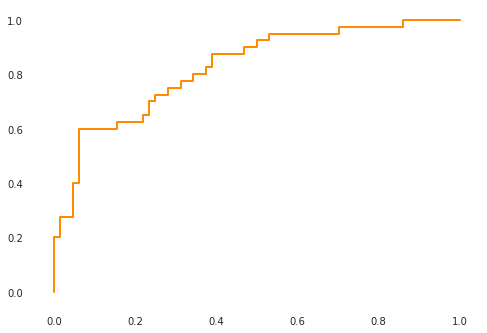

0.8202643047131124 2.4726351391038213
[0]	eval-auc:0.62676	train-auc:0.91195
[50]	eval-auc:0.87879	train-auc:1.00000
[99]	eval-auc:0.87068	train-auc:1.00000
[0]	eval-auc:0.73018	train-auc:0.93256
[50]	eval-auc:0.87140	train-auc:1.00000
[99]	eval-auc:0.87456	train-auc:1.00000
[0]	eval-auc:0.67290	train-auc:0.92868
[50]	eval-auc:0.81807	train-auc:1.00000
[99]	eval-auc:0.81807	train-auc:1.00000
[0]	eval-auc:0.70461	train-auc:0.93367
[50]	eval-auc:0.84514	train-auc:1.00000
[99]	eval-auc:0.84553	train-auc:1.00000
[0]	eval-auc:0.64869	train-auc:0.93171
[50]	eval-auc:0.87173	train-auc:1.00000
[99]	eval-auc:0.87909	train-auc:1.00000


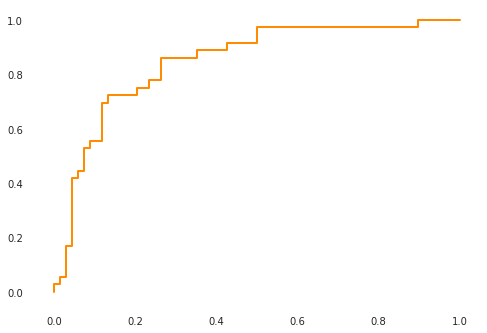

0.8101667031822644 3.2828018422860854
[0]	eval-auc:0.64556	train-auc:0.92598
[50]	eval-auc:0.85049	train-auc:1.00000
[99]	eval-auc:0.85523	train-auc:1.00000
[0]	eval-auc:0.65764	train-auc:0.92879
[50]	eval-auc:0.83026	train-auc:1.00000
[99]	eval-auc:0.84025	train-auc:1.00000
[0]	eval-auc:0.60389	train-auc:0.91063
[50]	eval-auc:0.81014	train-auc:1.00000
[99]	eval-auc:0.81205	train-auc:1.00000
[0]	eval-auc:0.64180	train-auc:0.92929
[50]	eval-auc:0.84922	train-auc:1.00000
[99]	eval-auc:0.85313	train-auc:1.00000
[0]	eval-auc:0.78084	train-auc:0.93556
[50]	eval-auc:0.82757	train-auc:1.00000
[99]	eval-auc:0.81818	train-auc:1.00000


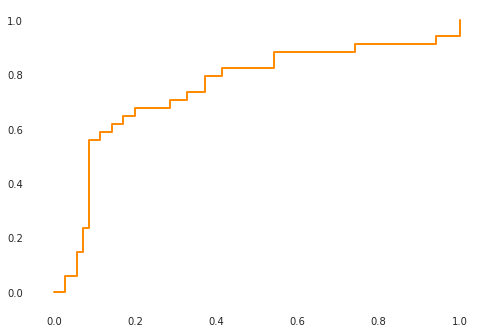

0.8141435580133056 4.096945400299391
[0]	eval-auc:0.69213	train-auc:0.95567
[50]	eval-auc:0.80207	train-auc:1.00000
[99]	eval-auc:0.80041	train-auc:1.00000
[0]	eval-auc:0.66144	train-auc:0.92369
[50]	eval-auc:0.78397	train-auc:1.00000
[99]	eval-auc:0.79520	train-auc:1.00000
[0]	eval-auc:0.65777	train-auc:0.91336
[50]	eval-auc:0.86177	train-auc:1.00000
[99]	eval-auc:0.85210	train-auc:1.00000
[0]	eval-auc:0.55540	train-auc:0.91600
[50]	eval-auc:0.78483	train-auc:1.00000
[99]	eval-auc:0.79310	train-auc:1.00000
[0]	eval-auc:0.56353	train-auc:0.91531
[50]	eval-auc:0.83582	train-auc:1.00000
[99]	eval-auc:0.83582	train-auc:1.00000


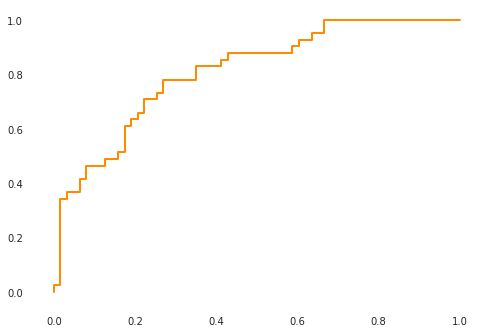

0.8468468956017222 4.943792295901113
[0]	eval-auc:0.74070	train-auc:0.92740
[50]	eval-auc:0.83891	train-auc:1.00000
[99]	eval-auc:0.83631	train-auc:1.00000
[0]	eval-auc:0.64441	train-auc:0.93152
[50]	eval-auc:0.83179	train-auc:1.00000
[99]	eval-auc:0.83098	train-auc:1.00000
[0]	eval-auc:0.58491	train-auc:0.93699
[50]	eval-auc:0.83179	train-auc:1.00000
[99]	eval-auc:0.83864	train-auc:1.00000
[0]	eval-auc:0.71509	train-auc:0.92881
[50]	eval-auc:0.83063	train-auc:1.00000
[99]	eval-auc:0.83198	train-auc:1.00000
[0]	eval-auc:0.72466	train-auc:0.93488
[50]	eval-auc:0.79211	train-auc:1.00000
[99]	eval-auc:0.80000	train-auc:1.00000


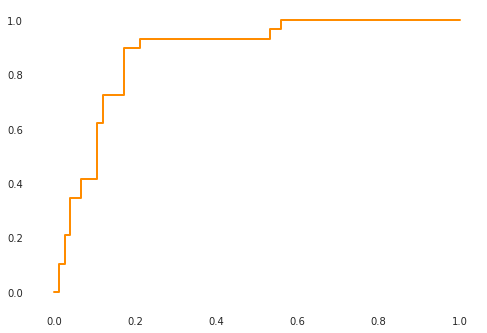

0.8605535704716649 5.804345866372778
[0]	eval-auc:0.68757	train-auc:0.91304
[50]	eval-auc:0.73961	train-auc:1.00000
[99]	eval-auc:0.74686	train-auc:1.00000
[0]	eval-auc:0.66217	train-auc:0.93419
[50]	eval-auc:0.81454	train-auc:1.00000
[99]	eval-auc:0.81904	train-auc:1.00000
[0]	eval-auc:0.69508	train-auc:0.93396
[50]	eval-auc:0.77917	train-auc:1.00000
[99]	eval-auc:0.79924	train-auc:1.00000
[0]	eval-auc:0.67619	train-auc:0.94300
[50]	eval-auc:0.82402	train-auc:1.00000
[99]	eval-auc:0.80290	train-auc:1.00000
[0]	eval-auc:0.74265	train-auc:0.92443
[50]	eval-auc:0.83520	train-auc:1.00000
[99]	eval-auc:0.83147	train-auc:1.00000


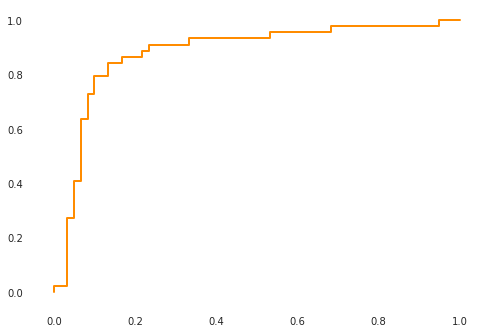

0.8298307937048705 6.634176660077648
[0]	eval-auc:0.60559	train-auc:0.92732
[50]	eval-auc:0.82360	train-auc:1.00000
[99]	eval-auc:0.81946	train-auc:1.00000
[0]	eval-auc:0.64115	train-auc:0.92051
[50]	eval-auc:0.84410	train-auc:1.00000
[99]	eval-auc:0.83891	train-auc:1.00000
[0]	eval-auc:0.68970	train-auc:0.93783
[50]	eval-auc:0.81378	train-auc:1.00000
[99]	eval-auc:0.80797	train-auc:1.00000
[0]	eval-auc:0.70403	train-auc:0.93092
[50]	eval-auc:0.84127	train-auc:1.00000
[99]	eval-auc:0.84708	train-auc:1.00000
[0]	eval-auc:0.70872	train-auc:0.94151
[50]	eval-auc:0.89132	train-auc:1.00000
[99]	eval-auc:0.89785	train-auc:1.00000


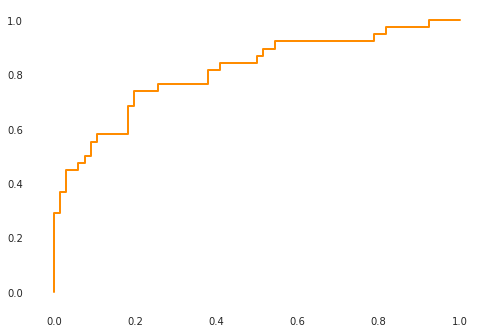

0.8320847267819624 7.46626138685961
[0]	eval-auc:0.64536	train-auc:0.92663
[50]	eval-auc:0.81223	train-auc:1.00000
[99]	eval-auc:0.83235	train-auc:1.00000
[0]	eval-auc:0.56781	train-auc:0.93010
[50]	eval-auc:0.74837	train-auc:1.00000
[99]	eval-auc:0.74346	train-auc:1.00000
[0]	eval-auc:0.75147	train-auc:0.94217
[50]	eval-auc:0.85672	train-auc:1.00000
[99]	eval-auc:0.86177	train-auc:1.00000
[0]	eval-auc:0.66471	train-auc:0.95150
[50]	eval-auc:0.87066	train-auc:1.00000
[99]	eval-auc:0.86589	train-auc:1.00000
[0]	eval-auc:0.68613	train-auc:0.93307
[50]	eval-auc:0.82031	train-auc:1.00000
[99]	eval-auc:0.83828	train-auc:1.00000


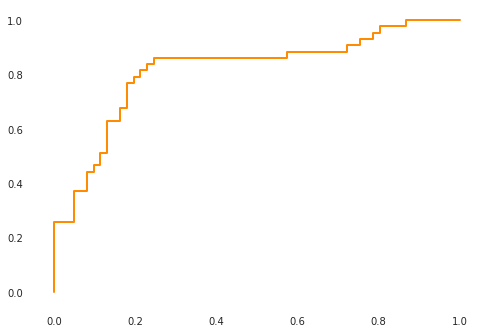

0.8473267488022348 8.313588135661846


In [141]:
%%capture
res_dict = {}
encoder = ce.backward_difference.BackwardDifferenceEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["BackwardDifferenceEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [143]:
%%capture
encoder = ce.binary.BinaryEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["BinaryEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [144]:
%%capture
encoder = ce.basen.BaseNEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["BaseNEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [145]:
%%capture
encoder = ce.hashing.HashingEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["HashingEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [146]:
%%capture
encoder = ce.helmert.HelmertEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["HelmertEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [148]:
%%capture
encoder = ce.one_hot.OneHotEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["OneHotEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [149]:
%%capture
encoder = ce.ordinal.OrdinalEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["OneHotEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [150]:
%%capture
encoder = ce.polynomial.PolynomialEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["OneHotEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [151]:
%%capture
encoder = ce.sum_coding.SumEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["OneHotEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

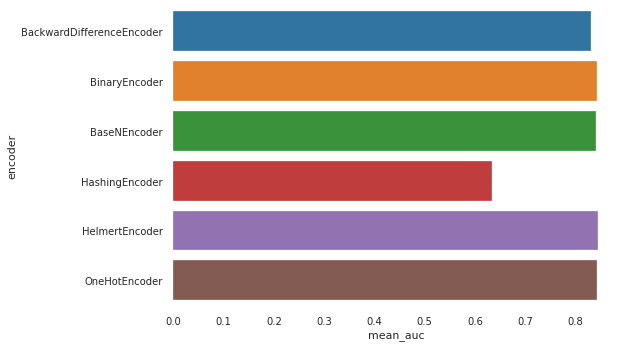

In [170]:
res_df = pd.DataFrame({"encoder": list(res_dict.keys()), "mean_auc": list(res_dict.values())})
sns.barplot(data = res_df, y = "encoder", x = "mean_auc")

In [161]:
from pprint import pprint
pprint(res_df)

                     encoder  mean_auc
0  BackwardDifferenceEncoder  0.831359
1              BinaryEncoder  0.843413
2               BaseNEncoder  0.839767
3             HashingEncoder  0.633894
4             HelmertEncoder  0.845647
5              OneHotEncoder  0.843604


## Logarytmowanie zmiennych ciągłych

Widzimy, że najlepiej wypada model dla głębokości około 40, ale ogólnie charakteryzuje się sporą wariancją wyniku accuracy

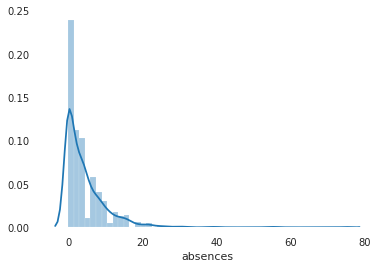

In [123]:
sns.distplot(df.absences)

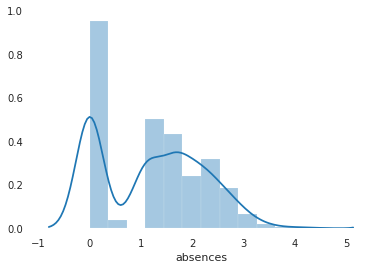

In [124]:
sns.distplot(np.log(df.absences+1)) # pytanie czy warto, może coś lepszego

In [220]:
df["absences"] = np.log(df.absences +1)

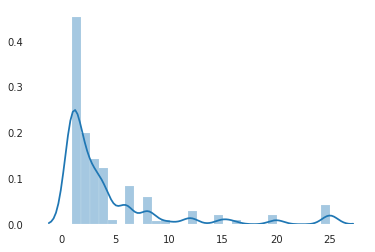

In [158]:
sns.distplot(df.loc[df.romantic_yes == 1].Walc * df.loc[df.romantic_yes == 1].Dalc)

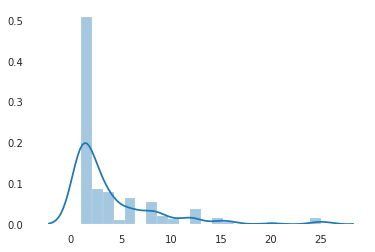

In [159]:
sns.distplot(df.loc[df.romantic_yes == 0].Walc * df.loc[df.romantic_yes == 0].Dalc)

## Nowe zmienne 

In [221]:
df["WeekandEnd"] = df.Walc * df.Dalc

In [222]:
acc_arr = np.zeros(20)
for i in range(20):
    acc2, _ = train_fast(df,40)
    acc_arr[i] = acc2

[0]	eval-auc:0.69847	train-auc:0.943899
[50]	eval-auc:0.769577	train-auc:1
[99]	eval-auc:0.762196	train-auc:1
[0]	eval-auc:0.655798	train-auc:0.934646
[50]	eval-auc:0.821396	train-auc:1
[99]	eval-auc:0.8366	train-auc:1
[0]	eval-auc:0.678363	train-auc:0.949497
[50]	eval-auc:0.795676	train-auc:1
[99]	eval-auc:0.793727	train-auc:1
[0]	eval-auc:0.535996	train-auc:0.915929
[50]	eval-auc:0.762777	train-auc:1
[99]	eval-auc:0.775966	train-auc:1
[0]	eval-auc:0.671387	train-auc:0.930621
[50]	eval-auc:0.845497	train-auc:1
[99]	eval-auc:0.837691	train-auc:1
[0]	eval-auc:0.744374	train-auc:0.945999
[50]	eval-auc:0.863193	train-auc:1
[99]	eval-auc:0.846004	train-auc:1
[0]	eval-auc:0.662301	train-auc:0.934734
[50]	eval-auc:0.823228	train-auc:1
[99]	eval-auc:0.831288	train-auc:1
[0]	eval-auc:0.622592	train-auc:0.921328
[50]	eval-auc:0.805581	train-auc:1
[99]	eval-auc:0.80216	train-auc:1
[0]	eval-auc:0.611786	train-auc:0.94098
[50]	eval-auc:0.810571	train-auc:1
[99]	eval-auc:0.808063	train-auc:1
[0]	ev

In [223]:
acc_arr.mean()       # ciut lepiej

0.7535031847133759

In [224]:
a = np.where((df.Dalc > 3)&(df.Walc <3),1,0 )   # wniosek z eda, osoby oznaczone w tej kolumnie jako 1, to wyłącznie romantycy
df["WeirdDrinker"] = a

In [225]:
acc_arr = np.zeros(20)
for i in range(20):
    acc3, _ = train_fast(df,40)
    acc_arr[i] = acc3

[0]	eval-auc:0.647882	train-auc:0.93077
[50]	eval-auc:0.742867	train-auc:1
[99]	eval-auc:0.761652	train-auc:1
[0]	eval-auc:0.651935	train-auc:0.952581
[50]	eval-auc:0.776598	train-auc:1
[99]	eval-auc:0.774437	train-auc:1
[0]	eval-auc:0.687144	train-auc:0.931398
[50]	eval-auc:0.837619	train-auc:1
[99]	eval-auc:0.839517	train-auc:1
[0]	eval-auc:0.701292	train-auc:0.947721
[50]	eval-auc:0.851659	train-auc:1
[99]	eval-auc:0.850116	train-auc:1
[0]	eval-auc:0.573943	train-auc:0.90367
[50]	eval-auc:0.747541	train-auc:1
[99]	eval-auc:0.748922	train-auc:1
[0]	eval-auc:0.608726	train-auc:0.935896
[50]	eval-auc:0.776566	train-auc:1
[99]	eval-auc:0.780084	train-auc:1
[0]	eval-auc:0.661058	train-auc:0.915763
[50]	eval-auc:0.768491	train-auc:1
[99]	eval-auc:0.780695	train-auc:1
[0]	eval-auc:0.605421	train-auc:0.927021
[50]	eval-auc:0.840085	train-auc:1
[99]	eval-auc:0.837963	train-auc:1
[0]	eval-auc:0.600734	train-auc:0.94493
[50]	eval-auc:0.816355	train-auc:1
[99]	eval-auc:0.802726	train-auc:1
[0]	

In [226]:
acc_arr.mean()      # już dużo lepiej niż oryginalnie

0.771656050955414

## PCA

In [203]:
from sklearn.decomposition import PCA

In [185]:
pca = PCA(n_components=10) 
principalComponents = pca.fit_transform(df.drop("romantic_yes", axis = 1))

cols = []
for i in range(10): 
    cols.append("pc"+str(i+1))

principalDf = pd.DataFrame(data = principalComponents, columns = cols)
principalDf

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,9.353774,-0.550099,-0.110924,1.886126,2.526790,1.923906,-1.242351,-0.024718,0.037111,0.616042
1,10.094487,-1.389813,-2.389793,-0.335878,1.051091,-0.025940,-1.065988,-0.697437,0.053942,0.416029
2,4.957534,0.323846,-2.723654,-0.444309,1.689641,-1.447474,1.149817,-0.858096,-0.621435,-0.693584
3,-6.021629,-1.902445,1.577135,-1.106217,0.872031,-0.140397,1.308566,-0.877959,-0.555090,0.681144
4,4.019292,-0.189450,-0.932625,-1.010804,3.890214,0.445719,0.270783,1.191066,-0.959605,0.038107
...,...,...,...,...,...,...,...,...,...,...
1039,1.678819,-0.104869,-0.122668,-1.480298,-0.138726,2.519995,-0.997655,0.763093,-0.258722,-0.676246
1040,-7.072694,-0.597366,-1.782231,1.796408,-1.610812,0.667217,-1.030189,-0.487840,-0.032344,0.276993
1041,1.331891,-2.302947,-1.179159,-2.085767,-1.457850,1.768753,3.105314,0.654245,-2.098445,0.207371
1042,2.377861,2.692444,-0.893670,1.841289,-1.186198,-1.044776,0.687772,-0.241463,-0.489388,-0.457325


In [187]:
pca.explained_variance_ratio_.cumsum()   # 65 % wariancji w 2 ważnych kolumnach

array([0.59902194, 0.65019026, 0.69491414, 0.73266921, 0.77016296,
       0.79725053, 0.82188999, 0.84136708, 0.8570918 , 0.87190621])

zredukowaliśmy wymiar do 10

In [188]:
pca_df = pd.concat([principalDf,df.romantic_yes],axis =1)
pca_df

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,romantic_yes
0,9.353774,-0.550099,-0.110924,1.886126,2.526790,1.923906,-1.242351,-0.024718,0.037111,0.616042,0
1,10.094487,-1.389813,-2.389793,-0.335878,1.051091,-0.025940,-1.065988,-0.697437,0.053942,0.416029,0
2,4.957534,0.323846,-2.723654,-0.444309,1.689641,-1.447474,1.149817,-0.858096,-0.621435,-0.693584,0
3,-6.021629,-1.902445,1.577135,-1.106217,0.872031,-0.140397,1.308566,-0.877959,-0.555090,0.681144,1
4,4.019292,-0.189450,-0.932625,-1.010804,3.890214,0.445719,0.270783,1.191066,-0.959605,0.038107,0
...,...,...,...,...,...,...,...,...,...,...,...
1039,1.678819,-0.104869,-0.122668,-1.480298,-0.138726,2.519995,-0.997655,0.763093,-0.258722,-0.676246,0
1040,-7.072694,-0.597366,-1.782231,1.796408,-1.610812,0.667217,-1.030189,-0.487840,-0.032344,0.276993,0
1041,1.331891,-2.302947,-1.179159,-2.085767,-1.457850,1.768753,3.105314,0.654245,-2.098445,0.207371,0
1042,2.377861,2.692444,-0.893670,1.841289,-1.186198,-1.044776,0.687772,-0.241463,-0.489388,-0.457325,0


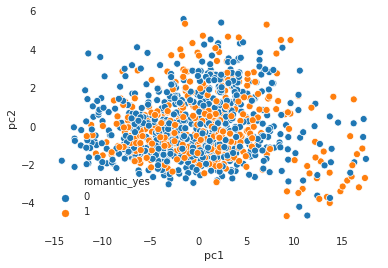

In [189]:
sns.scatterplot(x = "pc1", y = "pc2", data = pca_df, hue = "romantic_yes")  

Nie widać widocznego podziału danych

In [198]:
acc_arr = np.zeros(20)
for i in range(20):
    acc4, _ =  train_fast(pca_df,40)
    acc_arr[i] = acc3             

[0]	eval-auc:0.590414	train-auc:0.938522
[50]	eval-auc:0.66594	train-auc:1
[99]	eval-auc:0.651961	train-auc:1


/home/jakwisn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/jakwisn/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	eval-auc:0.564772	train-auc:0.947271
[50]	eval-auc:0.615975	train-auc:1
[99]	eval-auc:0.617512	train-auc:1
[0]	eval-auc:0.54392	train-auc:0.937361
[50]	eval-auc:0.641421	train-auc:1
[99]	eval-auc:0.656451	train-auc:1
[0]	eval-auc:0.534023	train-auc:0.942584
[50]	eval-auc:0.655626	train-auc:1
[99]	eval-auc:0.656166	train-auc:1
[0]	eval-auc:0.57507	train-auc:0.936163
[50]	eval-auc:0.627638	train-auc:1
[99]	eval-auc:0.619421	train-auc:1
[0]	eval-auc:0.551198	train-auc:0.929449
[50]	eval-auc:0.686093	train-auc:1
[99]	eval-auc:0.687545	train-auc:1
[0]	eval-auc:0.649788	train-auc:0.950377
[50]	eval-auc:0.678819	train-auc:1
[99]	eval-auc:0.689236	train-auc:1
[0]	eval-auc:0.588125	train-auc:0.915627
[50]	eval-auc:0.601607	train-auc:1
[99]	eval-auc:0.590893	train-auc:1
[0]	eval-auc:0.59386	train-auc:0.931298
[50]	eval-auc:0.698276	train-auc:1
[99]	eval-auc:0.695989	train-auc:1
[0]	eval-auc:0.503754	train-auc:0.953026
[50]	eval-auc:0.611404	train-auc:1
[99]	eval-auc:0.627435	train-auc:1
[0]	

In [200]:
acc_arr.mean()                                  # jest okej, ale lepiej gdy działamy na zwykłych danych

0.7388535031847134

In [227]:
df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,major_por,WeekandEnd,WeirdDrinker
0,18,4,4,2,2,0,4,3,4,1,1,3,1.945910,5,6,6,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0
1,17,1,1,1,2,0,5,3,3,1,1,3,1.609438,5,5,6,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0
2,15,1,1,1,2,3,4,3,2,2,3,3,2.397895,7,8,10,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,1,0,0,6,0
3,15,4,2,1,3,0,3,2,2,1,1,5,1.098612,15,14,15,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1,1,0,1,0
4,16,3,3,1,2,0,4,3,2,1,2,5,1.609438,6,10,10,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,2,0


Czyli najlepsze, bo ok 77% dostaliśmy accuracy modelu z kilkoma dodatkowymi kolumnami. Co jeszcze warto przemyśleć? Standaryzację zmiennych, jaki ma efekt dla modelu (dla tego powinien mieć żaden), na koniec projektu przemyślimy kilka modeli - drzewiaste, sieć nauronową oraz być może k średich. 